In [1]:
import sim as vrep
import numpy
get_ipython().run_line_magic('pylab', 'inline')


# In[51]:


vrep.simxFinish(-1)  # Close opened connections
clientID = vrep.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

if clientID != -1:
    print('Connected')

    # Now try to retrieve data in a blocking fashion (i.e. a service call):
    res, objs = vrep.simxGetObjects(clientID, vrep.sim_handle_all, vrep.simx_opmode_blocking)
    
    #handler for proximity sensor
    res, call= vrep.simxGetObjectHandle(clientID, 'Proximity_sensor', vrep.simx_opmode_oneshot_wait)
    asd=vrep.simxReadProximitySensor(clientID, call, vrep.simx_opmode_streaming)
    
    print(asd)
    
    # Get Object position
    name = 'Omnirob'
    err_code, cuboid = vrep.simxGetObjectHandle(clientID, name, vrep.simx_opmode_blocking)
    res, position = vrep.simxGetObjectPosition(clientID, cuboid, -1, vrep.simx_opmode_blocking)        
    print('Omnirob is at [x,y,z]=', position)
    
    # Now close the connection to CoppeliaSim:
    vrep.simxGetPingTime(clientID)
    vrep.simxFinish(clientID)
    print('Disconnected')
else:
    print('Failed connecting to remote API server')

Populating the interactive namespace from numpy and matplotlib
Connected
(1, False, [0.0, 0.0, 0.0], 0, [0.0, 0.0, 0.0])
Omnirob is at [x,y,z]= [1.723017692565918, -1.199987769126892, 0.17617282271385193]
Disconnected


In [2]:
class robot():
    
    def __init__(self, frame_name, motor_names=[], client_id=0):  
        # If there is an existing connection
        if client_id:
                self.client_id = client_id
        else:
            self.client_id = self.open_connection()
            
        self.motors = self._get_handlers(motor_names) 
        
        # Robot frame
        self.frame =  self._get_handler(frame_name)
                    
    def open_connection(self):
        vrep.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = vrep.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim 
        
        if clientID != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return clientID
        
    def close_connection(self):    
        vrep.simxGetPingTime(self.client_id)  # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive.
        vrep.simxFinish(self.client_id)  # Now close the connection to CoppeliaSim:
        print('Connection closed')
    
    def isConnected(self):
        c,result = vrep.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0         
        
    def _get_handler(self, name):
        err_code, handler = vrep.simxGetObjectHandle(self.client_id, name, vrep.simx_opmode_blocking)
        return handler
    
    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)
        
        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = vrep.simxSetJointTargetVelocity(self.client_id, 
                                                      motor, vel, vrep.simx_opmode_streaming)      
            
    def set_position(self, position, relative_object=-1):
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)        
        vrep.simxSetObjectPosition(clientID, self.frame, relative_object, position, vrep.simx_opmode_oneshot)
        
    def simtime(self):
        return vrep.simxGetLastCmdTime(self.client_id)
    
    def get_position(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, position = vrep.simxGetObjectPosition(self.client_id, self.frame, relative_object, vrep.simx_opmode_blocking)        
        return array(position)
    
    def get_object_position(self, object_name):
        # Get Object position in the world frame
        err_code, object_h = vrep.simxGetObjectHandle(self.client_id, object_name, vrep.simx_opmode_blocking)
        res, position = vrep.simxGetObjectPosition(self.client_id, object_h, -1, vrep.simx_opmode_blocking)
        return array(position)
    
    def get_object_relative_position(self, object_name):        
        # Get Object position in the robot frame
        err_code, object_h = vrep.simxGetObjectHandle(self.client_id, object_name, vrep.simx_opmode_blocking)
        res, position = vrep.simxGetObjectPosition(self.client_id, object_h, self.frame, vrep.simx_opmode_blocking)
        return array(position)

In [3]:
def traject(rp, dp):
    tf = 2.5
    tstep = 0.1
    a0 = numpy.array(rp)
    a1 = 0
    a2 = (3*numpy.array(dp)-3*a0)/tf**2
    a3 = (2*a0-2*numpy.array(dp))/tf**3

    # Time interval
    time_steps = linspace(0, tf, int(tf/tstep))

    for t in time_steps:
        # Compute the trajectory
        traj_point = double(a0+a1*t+a2*(t**2)+a3*(t**3))
        vel_traj = double(3*a3*(t**2)+2*a2*t+a1)

        # Location sesing
        robot_position = r.get_position()
    
        r.set_position(traj_point)
    
        time.sleep(tstep)

In [4]:
grid = [[0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0]]

In [5]:
import time
import cv2
r = robot('Quadricopter_target')
xmove=[x / 100.0 for x in range(225, -250, -50)]
xmoveeven=[x / 100.0 for x in range(-225, 250, 50)]
ymoveodd=[y / 100.0 for y in range(-225, 250, 50)]
ymoveeven=[y / 100.0 for y in range(225, -250, -50)]
z=1
count=1

#getting first image
res, v1 = vrep.simxGetObjectHandle(clientID, 'Vision_sensor', vrep.simx_opmode_oneshot_wait)
err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_streaming)
counti=0
countj=0
for x in xmove:
    countj=0
    if count%2==1:
        count+=1
        for y in ymoveodd:
            desired_position = [x, y, z]
            robot_position = r.get_position()
            traject(robot_position, desired_position)
            time.sleep(.5)
            #handler for vision sensor
            res, v1 = vrep.simxGetObjectHandle(clientID, 'Vision_sensor', vrep.simx_opmode_oneshot_wait)
            err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_streaming)
            obj=1
            for i in range(5):
                #taking Pics
                res, v1 = vrep.simxGetObjectHandle(clientID, 'Vision_sensor', vrep.simx_opmode_oneshot_wait)
                err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_streaming)
                time.sleep(1)
                res, v1 = vrep.simxGetObjectHandle(clientID, 'Vision_sensor', vrep.simx_opmode_oneshot_wait)
                err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_buffer)
                print(resolution)
                time.sleep(1)
                img = np.array(image,dtype=np.uint8)
                img.resize([resolution[1],resolution[0],3])
                
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                gray = cv2.medianBlur(gray,5)
                circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, gray.shape[0] / 8, param1=30,param2=15,minRadius=10,maxRadius=0)
        
                if circles is not None:
                    obj=0
                    
            grid[counti][countj]=obj
            countj+=1
            
    else:
        countj=10
        count+=1
        for y in ymoveeven:
            desired_position = [x, y, z]
            robot_position = r.get_position()
            traject(robot_position, desired_position)
            time.sleep(.5)
            obj=1
            for i in range(5):
                #taking Pics
                res, v1 = vrep.simxGetObjectHandle(clientID, 'Vision_sensor', vrep.simx_opmode_oneshot_wait)
                err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_streaming)
                time.sleep(1)
                res, v1 = vrep.simxGetObjectHandle(clientID, 'Vision_sensor', vrep.simx_opmode_oneshot_wait)
                err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_buffer)
                time.sleep(1)
                img = np.array(image,dtype=np.uint8)
                img.resize([resolution[1],resolution[0],3])
                
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                gray = cv2.medianBlur(gray,5)
                circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, gray.shape[0] / 8, param1=30,param2=15,minRadius=10,maxRadius=0)
                if circles is not None:
                    obj=0
                    
            grid[counti][countj]=obj
            countj-=1
    counti+=1           

Robot connected
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256, 256]
[256,

In [6]:
print(countj)

11


In [6]:
print(grid)

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [1, 0, 0, 0, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0, 0, 1], [1, 0, 0, 1, 1, 1, 1, 1, 1, 1]]


In [2]:
%pylab inline
n,m=10,10
grid_cells= np.zeros((10,10))


Populating the interactive namespace from numpy and matplotlib


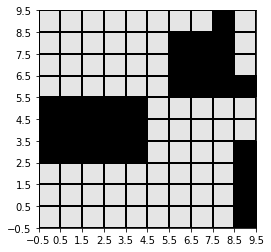

In [3]:
# Plot the grid
from matplotlib.colors import ListedColormap
def draw_grid():
    fig, ax = plt.subplots()
    cmap = ListedColormap(['0.9', 'black']) # Colors (0.9 is the almost white in gray scale)
    ax.imshow(grid, cmap=cmap, origin='lower')
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-0.5, m, 1));
    ax.set_yticks(np.arange(-0.5, n, 1));

draw_grid()

In [4]:
import networkx as nx
# This function automatically creates the graph in a grid.
G = nx.grid_2d_graph(n, m) 
print("Number of nodes in a full grid (n*m): ",len(G.nodes()))
# Delete nodes with obstacles
for i in range(n):
    for j in range(m):
        # if the node is an obstacle
        if grid[i][j] == 1:  
            G.remove_node((i,j))

print("Number of nodes after removing obstacles: ",len(G.nodes()))
print("Nodes:", G.nodes())

Number of nodes in a full grid (n*m):  100
Number of nodes after removing obstacles:  70
Nodes: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (3, 5), (3, 6), (3, 7), (3, 8), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 9), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 9), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 9)]


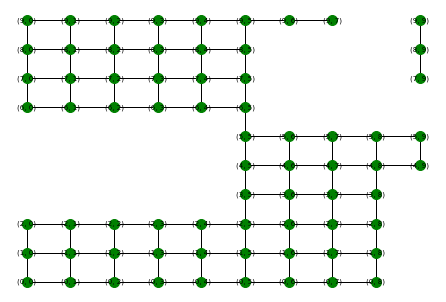

In [5]:
# Position of the nodes
pos = {node:(node[1], node[0]) for node in G.nodes()}  # by making (x,y) = (j, i), where i and j iterate over the columns and the rows respectively.
nx.draw(G, pos, font_size=7, with_labels=True, node_size=100, node_color="g")

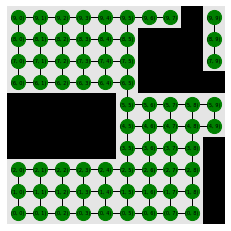

In [6]:
# Plot grid
draw_grid()

# Plot the graph
pos = {node:(node[1], node[0]) for node in G.nodes()}  # by making (x,y) = j, -i, where i and j iterate over the columns and the rows respectively.
nx.draw(G, pos, font_size=5, with_labels=True, node_size=200, node_color="g")

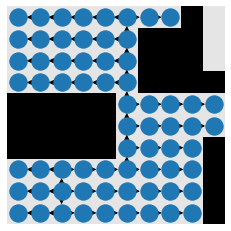

In [7]:
start_node =  (1, 2)
end_node = (8,0)

# Run BFS to generate a tree
bfs_tree = nx.bfs_tree(G, source=start_node)

draw_grid()
nx.draw(bfs_tree, pos = pos)

In [8]:
# Pick the last element and iterate through its predecessors
path = [end_node]   # A path in a graph is a set of connected nodes
current = end_node

# iterate through its predecessors until finding source node
while current != start_node:
    # Predecesors of the current node        
    for pre in bfs_tree.predecessors(current):
        current = pre
    # add the predecessor to the path
    path.append(pre)

[(1, 2), (2, 2), (2, 3), (2, 4), (2, 5), (3, 5), (4, 5), (5, 5), (6, 5), (7, 5), (8, 5), (8, 4), (8, 3), (8, 2), (8, 1), (8, 0)]


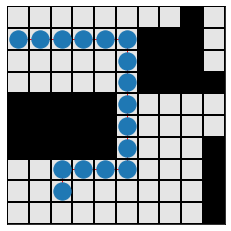

In [9]:
# The current path starts in the goal node and ends at the start node. So we invert it
path = path[::-1]

# Correct path
print(path)


# Edges of the path
E = [(path[i], path[i+1])for i in range(len(path)-1)]

draw_grid()
nx.draw_networkx_nodes(path, pos)
nx.draw_networkx_edges(G, edgelist=E, pos=pos,edge_color='r')

In [10]:
print(path)

[(1, 2), (2, 2), (2, 3), (2, 4), (2, 5), (3, 5), (4, 5), (5, 5), (6, 5), (7, 5), (8, 5), (8, 4), (8, 3), (8, 2), (8, 1), (8, 0)]


In [11]:
xmove=[x / 100.0 for x in range(225, -250, -50)]
ymove=[y / 100.0 for y in range(-225, 250, 50)]
countx=0
county=0
cords=[[0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0]]
for x in xmove:
    county=0
    for y in ymove:
        cords[countx][county]=[x,y]
        county+=1
    countx+=1

In [12]:
class robot2():
    
    def __init__(self, frame_name, motor_names=[], client_id=0):  
        # If there is an existing connection
        if client_id:
                self.client_id = client_id
        else:
            self.client_id = self.open_connection()
            
        self.motors = self._get_handlers(motor_names) 
        
        # Robot frame
        self.frame =  self._get_handler(frame_name)
            
        
    def open_connection(self):
        vrep.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = vrep.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim 
        
        if clientID != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return clientID
        
    def close_connection(self):    
        vrep.simxGetPingTime(self.client_id)  # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive.
        vrep.simxFinish(self.client_id)  # Now close the connection to CoppeliaSim:
        print('Connection closed')
    
    def isConnected(self):
        c,result = vrep.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0         
        
    def _get_handler(self, name):
        err_code, handler = vrep.simxGetObjectHandle(self.client_id, name, vrep.simx_opmode_blocking)
        return handler
    
    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)
        
        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = vrep.simxSetJointTargetVelocity(self.client_id, 
                                                      motor, vel, vrep.simx_opmode_streaming)      
            
    def set_position(self, position, relative_object=-1):
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)        
        vrep.simxSetObjectPosition(clientID, self.frame, relative_object, position, vrep.simx_opmode_oneshot)
        
    def simtime(self):
        return vrep.simxGetLastCmdTime(self.client_id)
    
    def get_position(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, position = vrep.simxGetObjectPosition(self.client_id, self.frame, relative_object, vrep.simx_opmode_blocking)        
        return array(position)
    
    def get_object_position(self, object_name):
        # Get Object position in the world frame
        err_code, object_h = vrep.simxGetObjectHandle(self.client_id, object_name, vrep.simx_opmode_blocking)
        res, position = vrep.simxGetObjectPosition(self.client_id, object_h, -1, vrep.simx_opmode_blocking)
        return array(position)
    
    def get_object_relative_position(self, object_name):        
        # Get Object position in the robot frame
        err_code, object_h = vrep.simxGetObjectHandle(self.client_id, object_name, vrep.simx_opmode_blocking)
        res, position = vrep.simxGetObjectPosition(self.client_id, object_h, self.frame, vrep.simx_opmode_blocking)
        return array(position)

In [13]:
def traject2(rp, dp):
    tf = 10.
    tstep = 0.1
    a0 = rp
    a1 = 0
    a2 = (3*dp-3*a0)/tf**2
    a3 = (2*a0-2*dp)/tf**3

    # Time interval
    time_steps = linspace(0, tf, int(tf/tstep))

    for t in time_steps:
        # Compute the trajectory
        traj_point = double(a0+a1*t+a2*(t**2)+a3*(t**3))
        vel_traj = double(3*a3*(t**2)+2*a2*t+a1)

        # Location sesing
        robot_position = r2.get_position()
    
        # drive the robot using the trajectory tracker
        u = 5*(traj_point - robot_position) + vel_traj
    
    
        vx, vy, vz = u
        r2.send_motor_velocities([-vy - vx, vy - vx, vy + vx, -vy + vx])
        time.sleep(tstep)


    
    r2.send_motor_velocities([0, 0, 0, 0])

In [ ]:
motor_names = ['Omnirob_FLwheel_motor', 'Omnirob_FRwheel_motor', 'Omnirob_RRwheel_motor', 'Omnirob_RLwheel_motor']
r2 = robot2('Omnirob', motor_names)  # Create an instance of our robot
for x in path:
    a=x[0]
    b=x[1]
    c=cords[a][b]
    desired_position=numpy.array([c[0],c[1],0])
    robot_position = r2.get_position()
    print(desired_position)
    traject2(robot_position, desired_position)

Robot connected
[ 1.75 -1.25  0.  ]
[ 1.25 -1.25  0.  ]
[ 1.25 -0.75  0.  ]
[ 1.25 -0.25  0.  ]
[1.25 0.25 0.  ]
[0.75 0.25 0.  ]
[0.25 0.25 0.  ]
[-0.25  0.25  0.  ]
[-0.75  0.25  0.  ]
[-1.25  0.25  0.  ]
[-1.75  0.25  0.  ]
[-1.75 -0.25  0.  ]
[-1.75 -0.75  0.  ]
[-1.75 -1.25  0.  ]
[-1.75 -1.75  0.  ]
[-1.75 -2.25  0.  ]
